# Homework 3

## Problem 1

We know that we want to find the dual linear program for this problem, but
first, we will find the primal linear program, and then convert it to the dual.

In [1]:
from scipy.optimize import linprog
import numpy as np

A = np.array([[1, 1],
              [12,5]])

b = np.array([7, 60])

c = np.array([9,5])

res = linprog(-1*c, A_ub=A, b_ub=b)
x = res.x
print(res)

     con: array([], dtype=float64)
     fun: -49.285714264563836
 message: 'Optimization terminated successfully.'
     nit: 4
   slack: array([3.04286907e-09, 2.56025317e-08])
  status: 0
 success: True
       x: array([3.57142857, 3.42857143])


Now we can go ahead an try converting this into a dual linear program

In [2]:
res_dual = linprog(b,A_ub = (-1)*A.T,b_ub = (-1)*c)
y = res_dual.x
print(res_dual)

     con: array([], dtype=float64)
     fun: 49.28571429146943
 message: 'Optimization terminated successfully.'
     nit: 4
   slack: array([1.51047885e-09, 1.05167430e-10])
  status: 0
 success: True
       x: array([2.14285714, 0.57142857])


### Dual prices are x

This is clearly done rather quickly in python, but we can also plot the feasible
region of the standard lin prog as well as the dual lin prog to see if our
maximal and minimal values make any sense.

In [3]:
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt

def plot_primal():
    plt.rcParams.update({'font.size': 19})

    d = np.linspace(-2,20,1000)
    x,y = np.meshgrid(d,d)

    pl = plt.figure(figsize=(10,10))
    ax = plt.axes()

    ax.imshow(((x >= 0) & (y >= 0) & (x + y <= 7) & (12*x + 5*y <= 60)).astype(int),
            extent    = (x.min(),x.max(),y.min(),y.max()),
            origin    = "lower", 
            cmap      = "Reds", 
            alpha     =  0.2,
            aspect    = "auto")

    # plot the lines defining the constraints
    x = np.arange(-2, 30, .1)
    ax.plot(x, 7 - x, label = "B + R <= 7")
    ax.plot(x, (60 - 12*x)/5,  label = "12B + 5R <= 60")

    ax.axhline(y=0, color = "black")
    ax.axvline(x=0, color = "black")
    ax.set_ylim(ymin=-5.0, ymax=25.5)

    ax.legend()
    ax.set_title("Feasible Region (Primal)")
    ax.set_xlabel("Gallons of Beans")
    ax.set_ylabel("Gallons of Rice")

    def ann_pt(x,y):
        s = f"({x},{y})"
        ax.annotate(s,xy=(x,y),xytext=(5,5),textcoords='offset points')

    ax.scatter(3.57, 3.42,s=100,color="blue")
    ann_pt(3.57, 3.42)


In [4]:
def plot_dual():
    plt.rcParams.update({'font.size': 19})

    d = np.linspace(-1,35,1500)
    x,y = np.meshgrid(d,d)

    pl = plt.figure(figsize=(10,10))
    ax = plt.axes()

    ax.imshow(((x >= 0) & (y >= 0) & (x + 12*y >= 9) & (x + 5*y >= 5)).astype(int),
            extent    = (x.min(),x.max(),y.min(),y.max()),
            origin    = "lower", 
            cmap      = "Reds", 
            alpha     =  0.2,
            aspect    = "auto")

    # plot the lines defining the constraints
    x = np.arange(-2, 30, .1)
    ax.plot(x, (5 - x)/5, label = "y1 + 12y2 >= 5")
    ax.plot(x, (9 - x)/12,  label = "y1 + 5y2 >= 9")

    ax.axhline(y=0, color = "black")
    ax.axvline(x=0, color = "black")
    ax.set_ylim(ymin=-1, ymax=5)

    ax.legend()
    ax.set_title("Feasible Region (Dual)")
    ax.set_xlabel("Gallons of Beans")
    ax.set_ylabel("Gallons of Rice")

    def ann_pt(x,y):
        s = f"({x},{y})"
        ax.annotate(s, xy = (x,y), xytext = (5,5), textcoords = 'offset points')

    ax.scatter(2.1428, .5714,s = 60, color = "blue")
    ann_pt(2.1428, 0.5714)


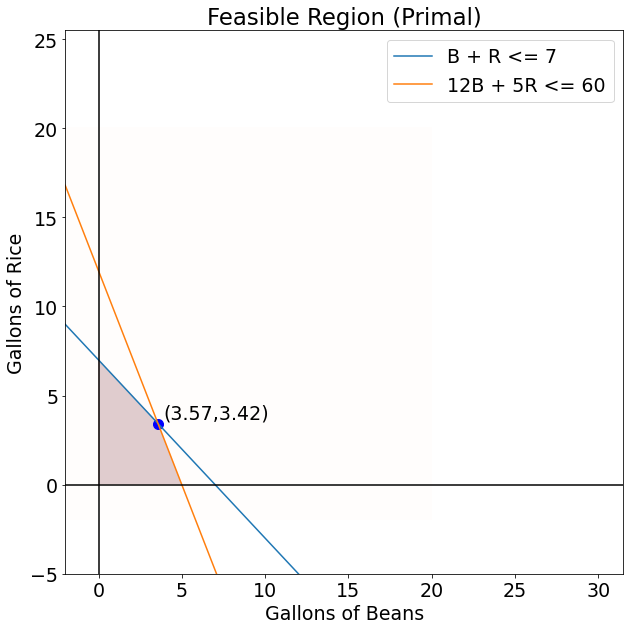

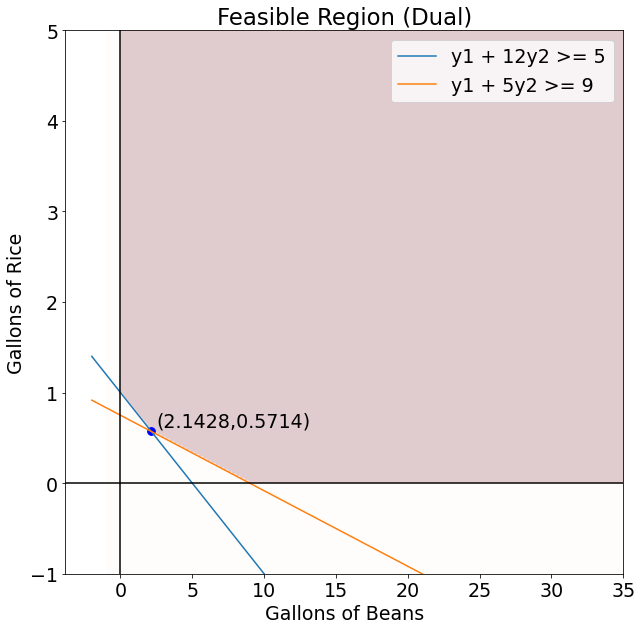

In [5]:
plot_primal()
plot_dual()

We now conern ourselves with whether or not strong duality is obeyed in this
circumstance. We know that strong duality dictates the following be true. <br>
$$ cx^*= b^T y^* $$
For c being the primal objective function, $b^T$ being the dual objective
function and $x^*, y^*$ being the optimal values in the primal and dual space
respectively. We can quickly check this via...

In [6]:
print(np.matmul(x,   c))
print(np.matmul(b.T, y))

49.285714264563836
49.28571429146943


Thus we can see that strong duality holds <br>
Another value of interest is the complementary slackness. We know that $x^*$ and
$y^*$ is only optimal if... <br>
$$ (b-Ax)^T \cdot y = 0 $$ 
and 
$$ (y^T A - c) \cdot x = 0 $$
hold. We can test this in the following way...

In [7]:
print(np.matmul((b - np.matmul(A,x)),y).T)
print(np.matmul((np.matmul(y.T, A) - c), x))

2.1150451805057904e-08
5.7551413769274575e-09


Both of these are sufficiently close to 0 to be within computational error

### Part c

We now want to know about how the dual price changes the primal objective
function under certain changes to the problem. <br>
Basically, I think we are just going to run the linprog over and over again
under the condition that the barrel holds either 1, 2, 4, or 6 gallons of food
and see if the dual price lemma is accurate and up to what degree.

In [8]:
def run_lin(brl):
    A = np.array([[1, 1],
                  [12,5]])

    b = np.array([brl, 60])

    c = np.array([9,5])

    prim_res = linprog(-1*c, A_ub=A, b_ub=b)
    dual_res = linprog(b, A_ub = (-1)*A.T, b_ub = (-1)*c)
    return [prim_res, dual_res]

def print_linprog(progs, num):
    print("LINPROG C =", num)
    print("   PRIMAL:")
    print(progs[0])
    print("   DUAL:")
    print(progs[1])
    print()

vals = [1, 2, 4, 6]

for i in vals:
    print_linprog(run_lin(i), i)


LINPROG C = 1
   PRIMAL:
     con: array([], dtype=float64)
     fun: -8.99999999419209
 message: 'Optimization terminated successfully.'
     nit: 5
   slack: array([-6.97772062e-10,  4.80000000e+01])
  status: 0
 success: True
       x: array([9.99999998e-01, 3.02196511e-09])
   DUAL:
     con: array([], dtype=float64)
     fun: 9.000000031983706
 message: 'Optimization terminated successfully.'
     nit: 5
   slack: array([1.52902402e-08, 4.00000001e+00])
  status: 0
 success: True
       x: array([9.00000001e+00, 3.47780528e-10])

LINPROG C = 2
   PRIMAL:
     con: array([], dtype=float64)
     fun: -17.999999996728942
 message: 'Optimization terminated successfully.'
     nit: 5
   slack: array([2.35272024e-10, 3.60000000e+01])
  status: 0
 success: True
       x: array([2.00000000e+00, 2.88401694e-10])
   DUAL:
     con: array([], dtype=float64)
     fun: 18.000000003843184
 message: 'Optimization terminated successfully.'
     nit: 5
   slack: array([8.14305068e-10, 4.00000000e+

# Problem 2

In [9]:
alpha = np.array([[  24,  76,  43, 754],
                  [75.5, 2.7, 3.3, 6.7],
                  [1, 0, 0, 0],
                  [0, 1, 0, 0],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]])

beta = np.array([[800, 85, 1, 1, 1, 1]])

cat = np.array([4976, 524, 3457, 5246])

res = linprog(-1*cat, A_ub = alpha, b_ub = beta)
print(res)

     con: array([], dtype=float64)
     fun: -13512.872821836372
 message: 'Optimization terminated successfully.'
     nit: 7
   slack: array([-5.51314997e-07,  2.02309991e-09,  4.16268921e-03,  9.99999981e-01,
       -6.68920319e-09,  2.77189610e-02])
  status: 0
 success: True
       x: array([9.95837311e-01, 1.86580741e-08, 1.00000001e+00, 9.72281039e-01])


This gives us some idea of what the crates should look like in an integer
programming setting. In order to maximize the profit, we should expect 1 crate
of a, c, and d, and zero of b.<br>
Now we look to integer linear programming.

In [53]:
### ATTEMPT ONE AT BRANCH AND BOUND
def test_all(a, b, c, d):
    mun = True
    epsilon = 0.0001
    weight = True

    ## test monetary constraint
    if(24.0*a + 76.0*b + 43.0*c + 754.0*d >= 800.0 + epsilon):
        #print("set mun false:", 24.0*a + 76.0*b + 43.0*c + 754.0*d)
        mun = False

    ## test weight constraint
    if(75.5*a + 2.7*b + 3.3*c + 6.7*d >= 85.0 + epsilon):
        #print("set weight false:", 75.5*a + 2.7*b + 3.3*c + 6.7*d)
        weight = False

    ## val of objective function
    val = 4976.0*a + 524.0*b + 3457.0*c + 5246.0*d

    return [mun, weight, val]

def f_report(vals):
    if(vals[0] == False or vals[1] == False):
        print("\tinfeasible")
    else:
        print("\tfeasible:", vals[2])


# test of optimal values in linprog


print("testing 0.9908, 0, 1, 0.9723")
f_report(test_all(res.x[0], res.x[1], res.x[2], res.x[3]))

print("TESTING X2") ## 1 infeasible, 0 feasible
f_report(test_all(res.x[0], 0, 1, res.x[3]))
f_report(test_all(res.x[0], 1, 1, res.x[3]))

print("TESTING X1") ## 1 infeasible, 0 feasible
f_report(test_all(0, 0, 1, res.x[3]))
f_report(test_all(1, 0, 1, res.x[3]))

print("TESTING X4")
f_report(test_all(0, 0, 1, 0))
f_report(test_all(0, 0, 1, 1))

testing 0.9908, 0, 1, 0.9723
	feasible: 13512.872821836372
TESTING X2
	feasible: 13512.872788934968
	infeasible
TESTING X1
	feasible: 8557.586330460308
	infeasible
TESTING X4
	feasible: 3457.0
	feasible: 8703.0


In [57]:
import sys
from graphviz import Graph

## https://www.graphviz.org/
## https://graphviz.readthedocs.io/en/stable/index.html

dot = Graph('bb1')

dot.node('S','S:\nv=11, x=(2, 1.8)',shape="square")

dot.node('S0','*pruned*\n\nS_0:\nv_0 = 2, x = (2,0)',shape="square")
dot.node('S1','*pruned*\n\nS_1:\nv_1 = 7, x = (2,1) ',shape="square")
dot.node('S2','\n\nS_2\nv_2 = 10, x=(0,2)',shape="square")


dot.edge('S','S0','x2=0')
dot.edge('S','S1','x2=1')
dot.edge('S','S2','x2=2')



ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

image.png